# CIFAR-10 Luokitteluprojekti (CNN)

In [169]:
from keras.src.layers import Dropout
from keras.src.utils import to_categorical
import keras
import numpy as np
from keras import layers
from matplotlib import pyplot as plt

In [170]:
# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One hot encode targets
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#### Modeling

The basic model quickly achieved around 75% accuracy, but further improvements were challenging to attain. Adding batch normalization boosted the accuracy by a few percentage points. Testing was also conducted with deeper models and additional dense layer at the end, but these models quickly overfitted. Few models with data augmentation were also built, but the training would take very large amount of time and the models actually performed worse than the models without augmentation.

In [171]:
# Create the model
inputs = keras.Input(shape=(32, 32, 3))

x = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="CIFAR_10_CNN")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [172]:
model.summary()

Model: "CIFAR_10_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,274 (387.79 KB)

 Trainable params: 98,826 (386.04 KB)

 Non-trainable params: 448 (1.75 KB)

#### Callbacks
During the training of the CNN, we observed that the model began to overfit after several epochs. To combat this, we used EarlyStopping and ReduceLROnPlateau callbacks. This allowed us to prevent retraining the model from scratch each time overfitting occurred.

In [173]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [174]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3573 - loss: 2.1743 - val_accuracy: 0.5972 - val_loss: 1.1648 - learning_rate: 0.0010
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5785 - loss: 1.2125 - val_accuracy: 0.5882 - val_loss: 1.1450 - learning_rate: 0.0010
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6287 - loss: 1.0538 - val_accuracy: 0.6638 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6647 - loss: 0.9694 - val_accuracy: 0.5810 - val_loss: 1.2406 - learning_rate: 0.0010
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6915 - loss: 0.8878 - val_accuracy: 0.6932 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7074 - loss: 0.8350 - val_accuracy: 0.6604 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy

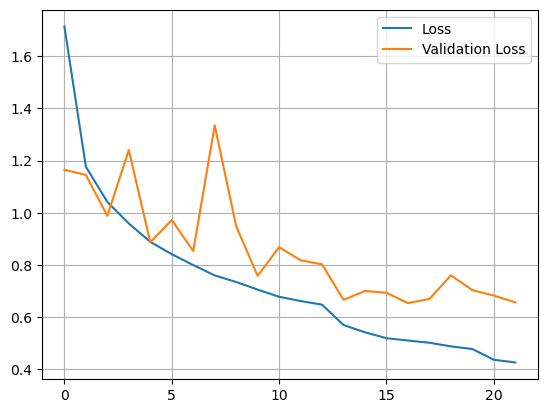

In [175]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [176]:
test_scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

Test loss: 0.68
Test accuracy: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


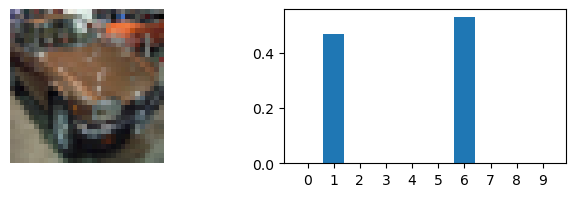

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


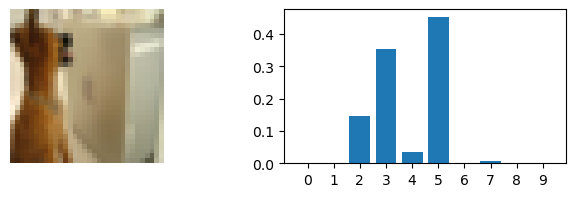

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


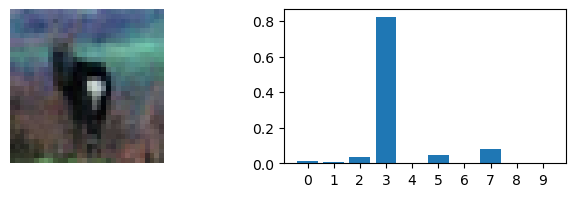

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


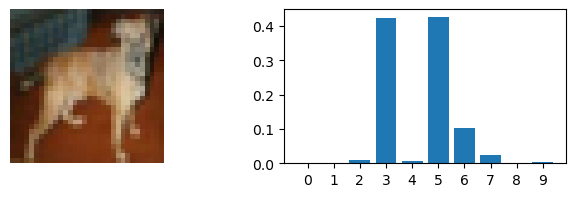

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


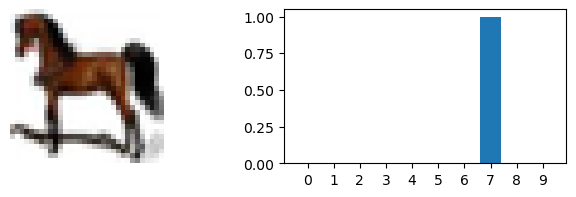

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


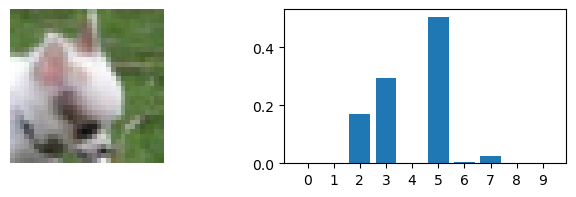

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


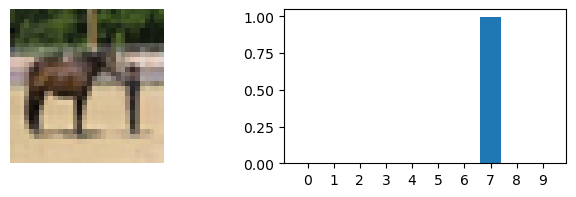

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


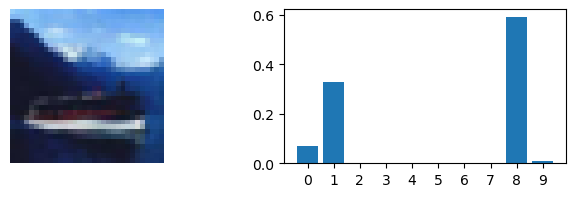

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


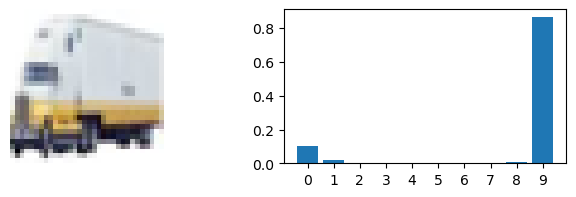

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


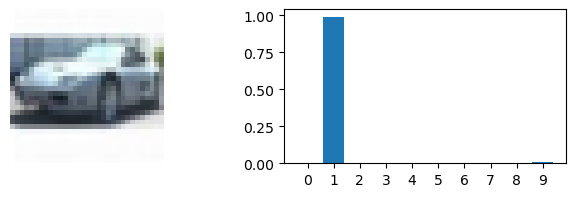

In [177]:
start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = model.predict(x)[0]

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k])
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), y)
    plt.xticks(range(10))

    plt.show()